In [32]:
%config Completer.use_jedi = False

In [33]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.LogDataHandling import *
from Problem.PerformanceObserver import *

from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.utils import *
from Problem.Sigma_adapted_functions  import *
# 2 3 11
fraction_type = "3"
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "UK25_2"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000
dataset = "fraction_{}".format(fraction_type)
sigma_routes = pd.read_pickle("sigma_data/sigma_solutions.pickle")[int(fraction_type)].to_list()[0]

sigma_starts = [s[0] for s in sigma_routes]
sigma_ends = [s[-1] for s in sigma_routes]

fraction_max_weight = {"2":500,"3":300,"11":1000}

sigma_data = pd.read_csv("sigma_data/data_frac_{}.csv".format(fraction_type))
pickups = sigma_data.where(sigma_data.Type ==1).dropna()
dropoffs = sigma_data.where(sigma_data.Type >1).dropna()
terminals = sigma_data.where(sigma_data.Type == 3).dropna()
sigma_demands_DF = separate_large_demands(sigma_data,fraction_max_weight[fraction_type],sigma_starts)
sigma_demands = sigma_demands_DF.Demand.astype(float).to_numpy()
sigma_station_data = sigma_demands_DF.rename(columns={"Demand":"Demand(kg)"})#pd.DataFrame(data=sigma_demands,columns=["Demand(kg)"])
meta_data["Customer Amount"] = len(sigma_data)
sigma_lat = sigma_data.Lat.to_numpy()
sigma_long = sigma_data.Long.to_numpy()
sigma_coordinates = np.array([sigma_lat,sigma_long]).T


sigma_distance_matrix,sigma_time_matrix = load_saved_here_data("sigma_data/","sigma_{}".format(fraction_type))#
sigma_distance_matrix = sigma_distance_matrix.to_numpy()
sigma_time_matrix = sigma_time_matrix.to_numpy()

dataset_names = ["fraction_2","fraction_3","fraction_11"]
sigma_routing_context = RoutingContext(distance_matrix=sigma_distance_matrix,time_matrix=sigma_time_matrix,station_coordinates=sigma_coordinates,station_data=sigma_station_data,meta_data=meta_data)
sigma_routes = pd.read_pickle("sigma_data/sigma_solutions.pickle")


In [34]:
optimal_parameters = {"SA":{"mutation":0.9}, "GA":{"mutation":0.9,"crossover":0.25,"population_size":30},
                     "NSGAII":{"mutation":0.9,"crossover":0.50,"population_size":30},
                     "NSGAIII":{"mutation":0.9,"crossover":0.50,"population_size":20},
                     "UNSGAIII":{"mutation":0.9,"crossover":0.25,"population_size":20},
                     "IBEA":{"mutation":0.9,"crossover":0.75,"population_size":20}}

In [35]:
imgs_path = "../src/imgs"

In [36]:
from datetime import timedelta
def time_string_to_minutes(time_string):
    """
    https://stackoverflow.com/a/60638687/12463908
    """
    
    h =time_string
    delta = timedelta(hours=int(h.split(':')[0]), minutes=int(h.split(':')[1]), seconds=int(h.split(':')[2]))
    minutes = delta.total_seconds()/60
    return minutes

def get_sigma_results():
    logpath = "parameter_data/sigma_results/"
    
    frac_2 = pd.read_csv("{}/fraction_2/sigma_results.csv".format(logpath))
    frac_3 = pd.read_csv("{}/fraction_3/sigma_results.csv".format(logpath))
    frac_11 = pd.read_csv("{}/fraction_11/sigma_results.csv".format(logpath))
    
    return frac_2,frac_3,frac_11

def get_initial_results():
    
    logpath = "parameter_data/sigma_results/"
    
    frac_2 = pd.read_csv("{}/fraction_2/initial_solution.csv".format(logpath))
    frac_3 = pd.read_csv("{}/fraction_3/initial_solution.csv".format(logpath))
    frac_11 = pd.read_csv("{}/fraction_11/initial_solution.csv".format(logpath))
    
    return frac_2,frac_3,frac_11
        

# Helper functions

In [37]:
def _mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), sp.stats.sem(a)
    h = se * sp.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def find_fithess_within_percentage_df(dataframe,percentage):
    time_points=[]
    for index,row in dataframe.iterrows():
        final_val = row.fuel_consumption_final
        worst_value_index = np.argsort(row.fuel_consumption)[-1] 

        percentage_range_value = final_val * (1 + percentage)
        if (worst_value := np.array(row.fuel_consumption)[worst_value_index])  < percentage_range_value:
                percentage_range_value = worst_value 

        if final_val == worst_value:
            time_points.append(np.array(row.computation_times)[0])
            continue

        within_range = np.argwhere(np.diff(np.sign(percentage_range_value - np.array(row.fuel_consumption)))).flatten()
        result = list(filter(lambda x: x >= worst_value_index,within_range))[0]
        time_points.append(np.array(row.computation_times)[result])
    return time_points


def add_final_compute_time_column(dataframe):
    if not "computation_times_final" in dataframe.columns:
        if type(dataframe.computation_times.iloc[0]) == str:
            dataframe.computation_times = dataframe.computation_times.apply(literal_eval)
        
        
        dataframe["computation_times_final"] = find_fithess_within_percentage_df(dataframe,0.05)#[dataframe.computation_times.loc[i][-1] for i in list(dataframe.index)]


def combine_datasets(algorithm_name, log_data_path, datasets=["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]):
    simulations = []
    if type(datasets) == list:
        for dataset_name in datasets:
            try:
                simulation = pd.read_csv("%s%s/%s.csv" % (log_data_path, dataset_name, algorithm_name))
            except:
                print("Error, file not found: %s%s/%s.csv" % (log_data_path, dataset_name, algorithm_name))
            if dataset_name == "UK25_2":
                try:
                    simulation = remove_unwanted_mutation_parameter_groups(simulation)
                    if algorithm_name == "SA":
                        simulation["Parameter Group"] = simulation["Parameter Group"]/2
                    else:
                        simulation["Parameter Group"] = sorted(list(range(45)) * 30)
                except:
                    #print("No parameter groups to alter.")
                    pass
            simulation["dataset"] = dataset_name
            simulations.append(simulation)
    else:
            try:
                simulation = pd.read_csv("%s%s/%s.csv" % (log_data_path, datasets, algorithm_name))
            except:
                print("Error, file not found: %s%s/%s.csv" % (log_data_path, datasets, algorithm_name))
            if datasets == "UK25_2":
                try:
                    simulation = remove_unwanted_mutation_parameter_groups(simulation)
                    if algorithm_name == "SA":
                        simulation["Parameter Group"] = simulation["Parameter Group"]/2
                    else:
                        simulation["Parameter Group"] = sorted(list(range(45)) * 30)
                except:
                    #print("No parameter groups to alter.")
                    pass
            simulation["dataset"] = datasets
            simulations.append(simulation)
        
    
    for df in simulations:
        add_final_fitness_columns(df)
        try:
            expand_parameter_colums(df)
        except:
            #print("No parameter columns to expand")
            pass
        add_distance_to_origin(df)
        add_final_compute_time_column(df)
        
        df["num_evaluations"] = len(df.fitness.apply(literal_eval).apply(np.array)[0])*60
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.fuel_consumption_final)
        df["fuel_consumption_final_mean"] = mean_f0
        df["fuel_consumption_final_min"] = min_f0
        df["fuel_consumption_final_max"] = max_f0
        
        max_fuel_consumption = max(df.fuel_consumption_final)
        min_fuel_consumption = min(df.fuel_consumption_final)
        df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption - min_fuel_consumption)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.fuel_consumption_final_minmax)
        df["fuel_consumption_final_minmax_mean"] = mean_f0
        df["fuel_consumption_final_minmax_min"] = min_f0
        df["fuel_consumption_final_minmax_max"] = max_f0
        
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.longest_route_time_final)
        df["longest_route_time_final_mean"] = mean_f0
        df["longest_route_time_final_min"] = min_f0
        df["longest_route_time_final_max"] = max_f0
        
        max_longest_route_time_final = max(df.longest_route_time_final)
        min_longest_route_time_final = min(df.longest_route_time_final)
        df["longest_route_time_final_minmax"] = (df.longest_route_time_final - min_longest_route_time_final)/(max_longest_route_time_final - min_longest_route_time_final)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.longest_route_time_final_minmax)
        df["longest_route_time_final_minmax_mean"] = mean_f0
        df["longest_route_time_final_minmax_min"] = min_f0
        df["longest_route_time_final_minmax_max"] = max_f0
        
        
        
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.computation_times_final)
        df["computation_times_final_mean"] = mean_f0
        df["computation_times_final_min"] = min_f0
        df["computation_times_final_max"] = max_f0
        
        max_computation_times_final = max(df.computation_times_final)
        min_computation_times_final = min(df.computation_times_final)
        df["computation_times_final_minmax"] = (df.computation_times_final - min_computation_times_final)/(max_computation_times_final - min_computation_times_final)

        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.distance_to_origin)
        df["distance_to_origin_mean"] = mean_f0
        df["distance_to_origin_min"] = min_f0
        df["distance_to_origin_max"] = max_f0
        
        max_distance_to_origin = max(df.distance_to_origin)
        min_distance_to_origin = min(df.distance_to_origin)
        df["distance_to_origin_minmax"] = (df.distance_to_origin - min_distance_to_origin)/(max_distance_to_origin - min_distance_to_origin)
        
    return pd.concat(simulations)



def plot_2d_sigma(datapoints, labels, show_mean_eval=False, marker_kwargs={"SA":{"color":"#1f77b4", "marker":"o"}, "NSGA-II": {"color":"#ff7f0e", "marker":"P"}, "NSGA-III":{"color":"#2ca02c", "marker":"s"}, "IBEA":{"color":"#d62728", "marker":"D"}, "IBEA-Adaptive":{"color":"#9467bd", "marker":">"}, "UNSGA-III":{"color":"#8c564b", "marker":"X"}, "GA":{"color":"#e377c2", "marker":"p"}}):
    
    
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig,ax = plt.subplots(1,1)
    for data, label in zip(datapoints, labels):

        mean_f0,min_f0,max_f0 =  data.fuel_consumption_final_mean, data.fuel_consumption_final_min, data.fuel_consumption_final_max
        mean_f1,min_f1,max_f1 =  data.longest_route_time_final_mean, data.longest_route_time_final_min, data.longest_route_time_final_max
        
        
        
        ax.plot([min_f0,max_f0],[mean_f1,mean_f1],zorder=1, c="k", linestyle="--")
       
        ax.plot([mean_f0,mean_f0],[min_f1,max_f1],zorder=1, c="k", linestyle="--")
        if show_mean_eval:
            plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {} \nMean Evaluations: {}".format(
                                                                                     round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                                     round(min_f1,2),round(mean_f1,2),round(max_f1,2), round(data.num_evaluations))
        else:
            plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}".format(
                                                                         round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                         round(min_f1,2),round(mean_f1,2),round(max_f1,2))

        ax.scatter(x= mean_f0, y=mean_f1, label=plotlabel, s=250, **marker_kwargs[label], zorder=2)
        
    return fig, ax


In [38]:
def get_vehicles_for_fraction(fraction_typeterminals):
    sigma_routes = pd.read_pickle("sigma_data/sigma_solutions.pickle")[int(fraction_type)].to_list()[0]
    sigma_data = pd.read_csv("sigma_data/data_frac_{}.csv".format(fraction_type))
    terminals = sigma_data.where(sigma_data.Type == 3).dropna()
    sigma_starts = [s[0] for s in sigma_routes]

    startNodeIndeces = sigma_starts + terminals.index.to_list()
    vehicleData = {"emptyWeights":[3000],"maxLoads":[3650],"fuelEmpty":[12],"fuelFull":[15]}
    vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,
                                                                routingContext=None)
    return vehicles

In [39]:
import time 
labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
start_time = time.monotonic()

print("SA")
SA_data = combine_datasets("SA", "parameter_data/sigma_results/",dataset_names)
print("GA")
GA_data = combine_datasets("GA", "parameter_data/sigma_results/",dataset_names)
print("NSGA2")
NSGA2_data = combine_datasets("NSGA2", "parameter_data/sigma_results/",dataset_names)
print("NSGA3")
NSGA3_data = combine_datasets("NSGA3", "parameter_data/sigma_results/",dataset_names)
print("UNSGA3")
UNSGA3_data = combine_datasets("UNSGA3", "parameter_data/sigma_results/",dataset_names)
print("IBEA")
IBEA_data = combine_datasets("IBEA", "parameter_data/sigma_results/",dataset_names)

# add_minmax_fuel_drivetime_columns([SA_data,GA_data,
#                                    NSGA2_data,NSGA3_data,
#                                    UNSGA3_data,IBEA_data])

SA_data_mean = SA_data.mean()
GA_data_mean = GA_data.mean()
NSGA2_data_mean = NSGA2_data.mean()
NSGA3_data_mean = NSGA3_data.mean()
UNSGA3_data_mean = UNSGA3_data.mean()
IBEA_data_data_mean = IBEA_data.mean()


print("Time: ", time.monotonic() - start_time)

SA
GA
NSGA2
NSGA3
UNSGA3
IBEA
Time:  0.6818178039975464


# Show comparison with Sigma and Initial Solution

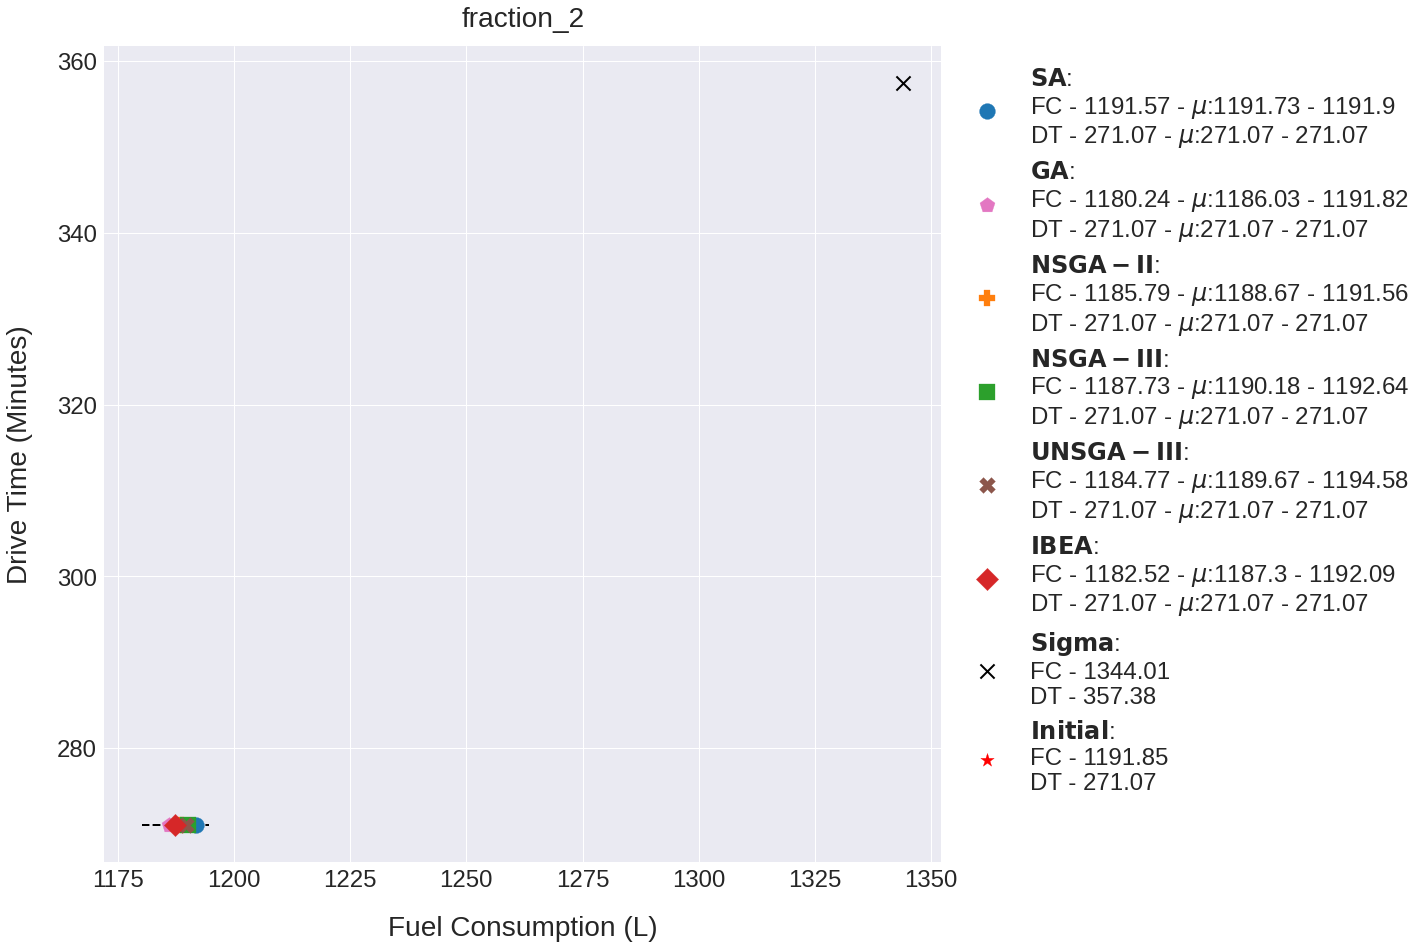

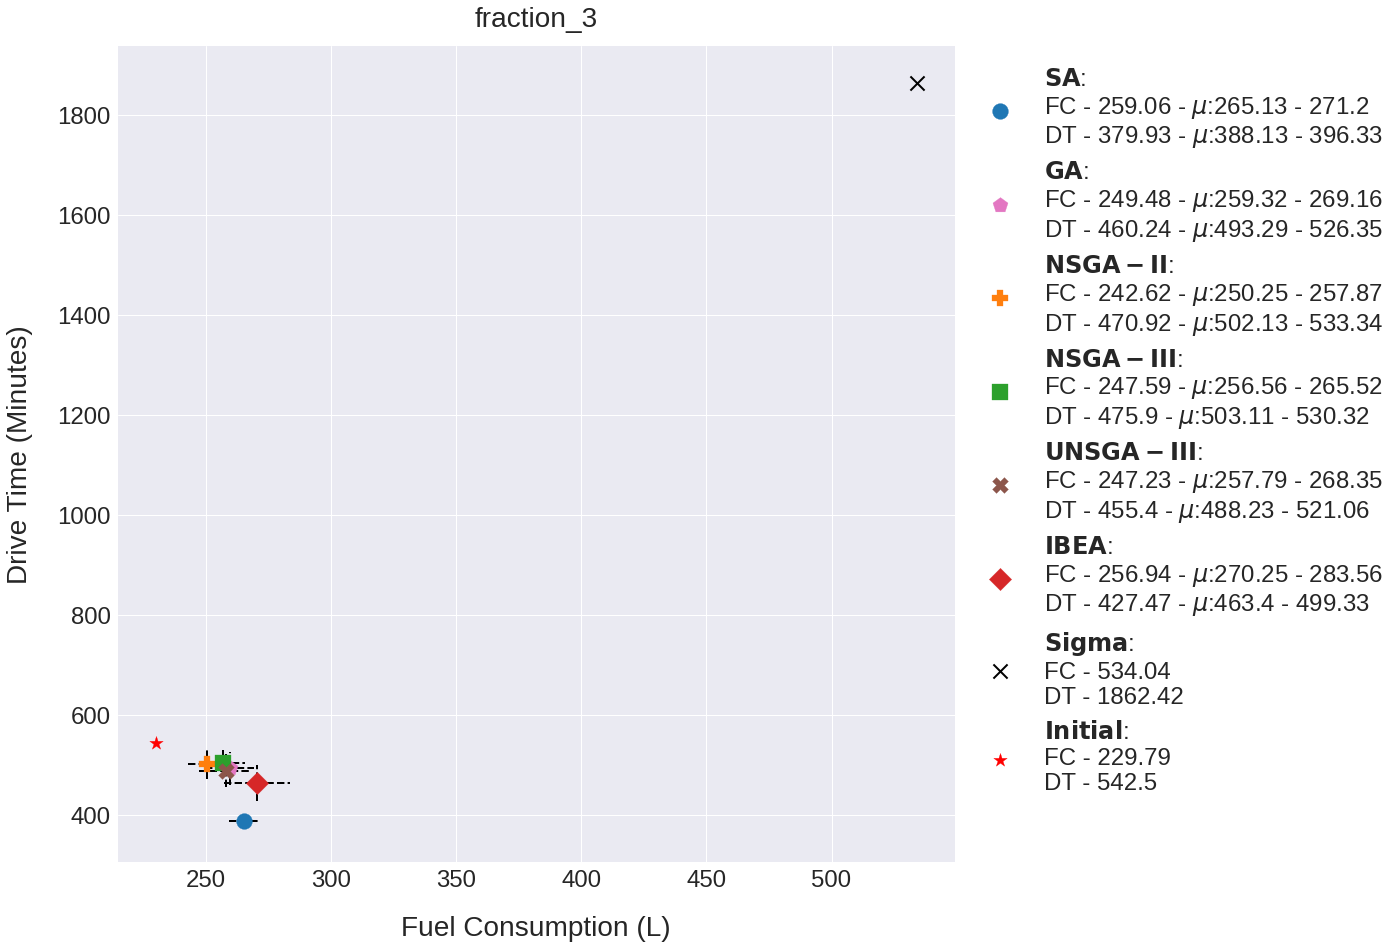

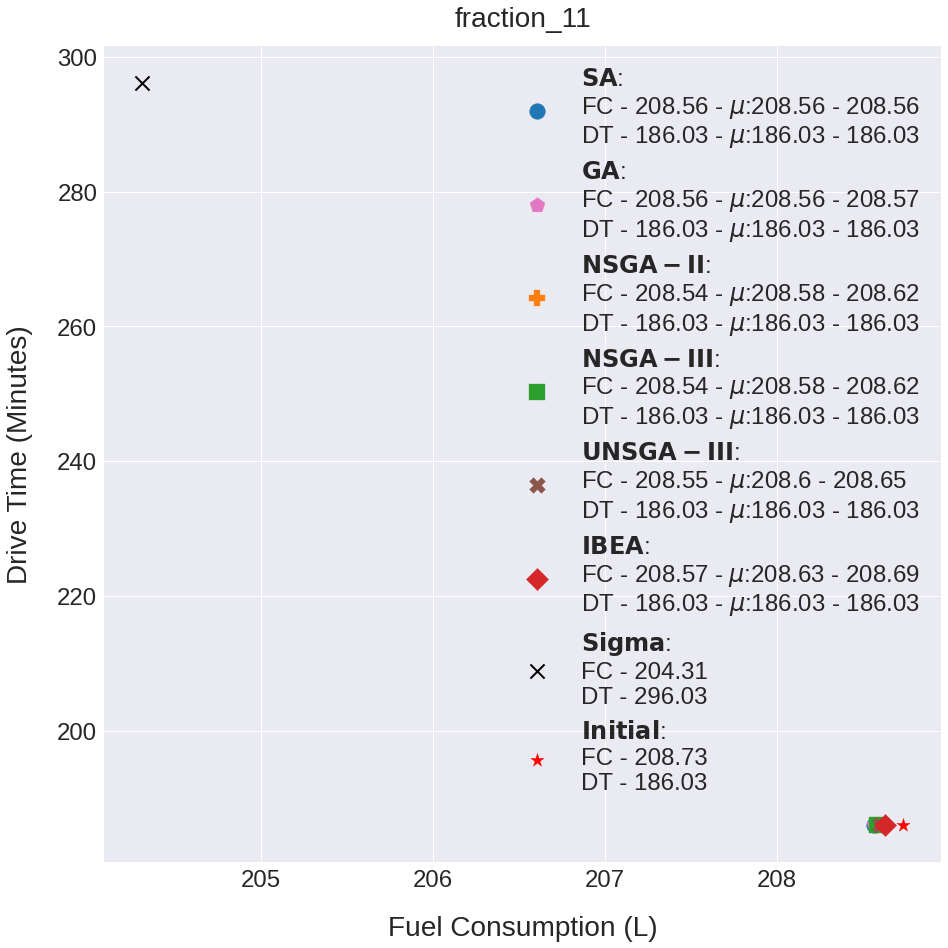

In [40]:
for dataset,sigma_sol,initial_sol in zip(dataset_names,get_sigma_results(),get_initial_results()):
    SA_data_dataset = SA_data.where(SA_data.dataset == dataset).dropna(how="all").mean()
    GA_data_dataset = GA_data.where(GA_data.dataset == dataset).dropna(how="all").mean()
    NSGA2_data_dataset = NSGA2_data.where(NSGA2_data.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data.where(NSGA3_data.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data.where(UNSGA3_data.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data.where(IBEA_data.dataset == dataset).dropna(how="all").mean()

    algorithms = [SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset]
    
    
    fig, ax = plot_2d_sigma(algorithms, labels)
    
    sigma_fuel = sigma_sol["Fuel Consumption (L)"].sum()
    sigma_drivetime = time_string_to_minutes(sigma_sol["Total Travel Time (h)"].max())
    sigma_label = r"$\bf{Sigma}$" + ":\nFC - {} \nDT - {} ".format(np.round(sigma_fuel,2),np.round(sigma_drivetime,2))
                                                                                     
    
    
    
    ax.scatter(x=sigma_fuel,y=sigma_drivetime,color="k",marker="x",s=200,label=sigma_label)
    
    
    initial_fuel = initial_sol["Fuel Consumption (L)"].sum()
    initial_drivetime = time_string_to_minutes(initial_sol["Total Travel Time (h)"].max())
    initial_label = r"$\bf{Initial}$" + ":\nFC - {} \nDT - {} ".format(np.round(initial_fuel,2),np.round(initial_drivetime,2))
    
    ax.scatter(x=initial_fuel,y=initial_drivetime,color="red",marker="*",s=200,label=initial_label)
    
    initial_sol
    
    
    plt.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
    
    
    
    plt.title(dataset)
    plt.show()

# Show without Sigma Comparison

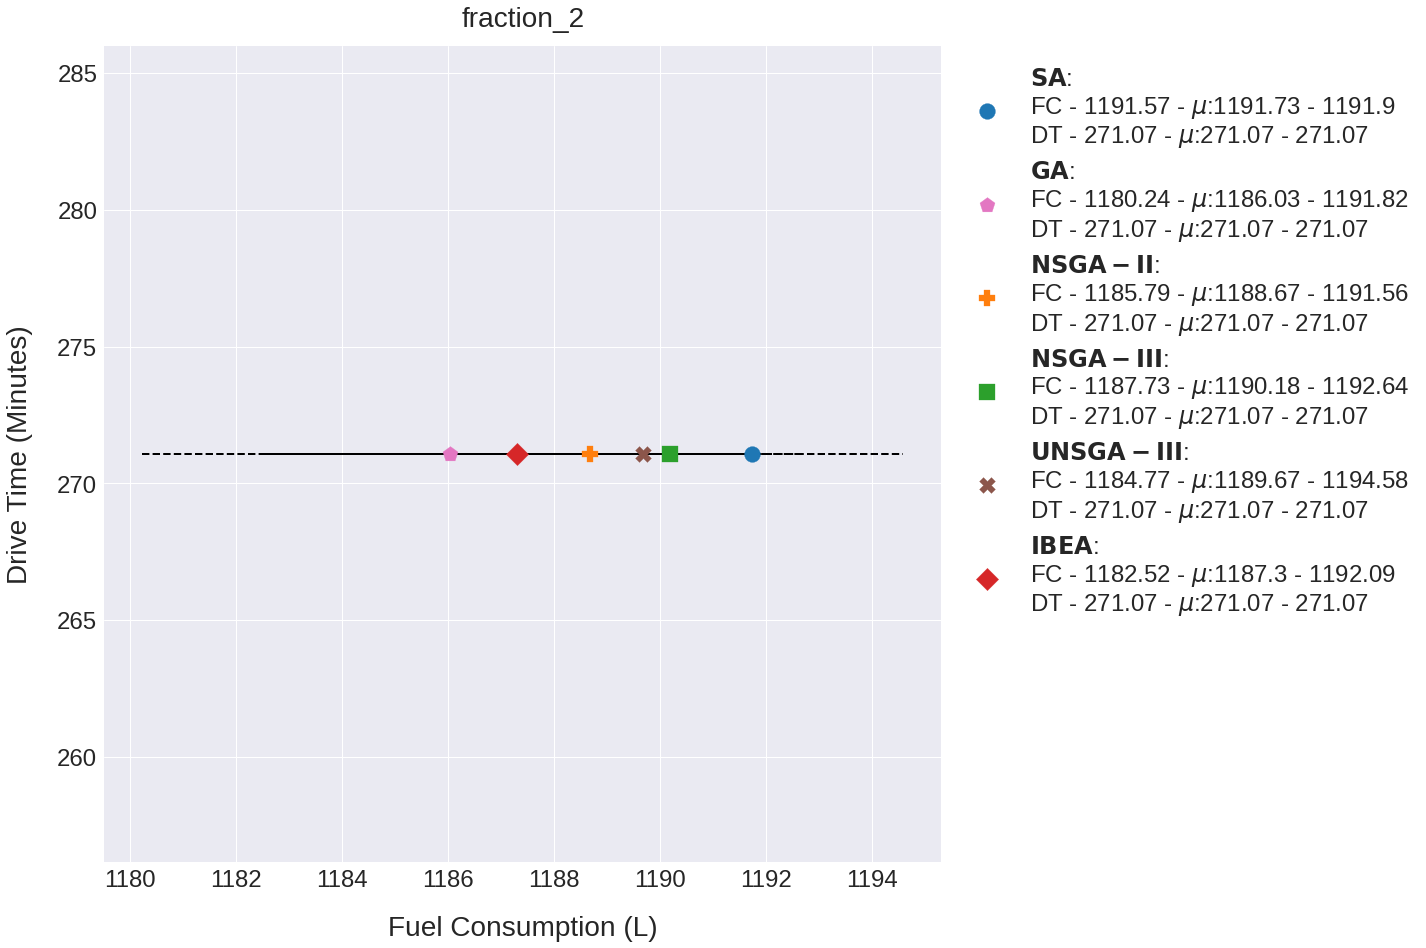

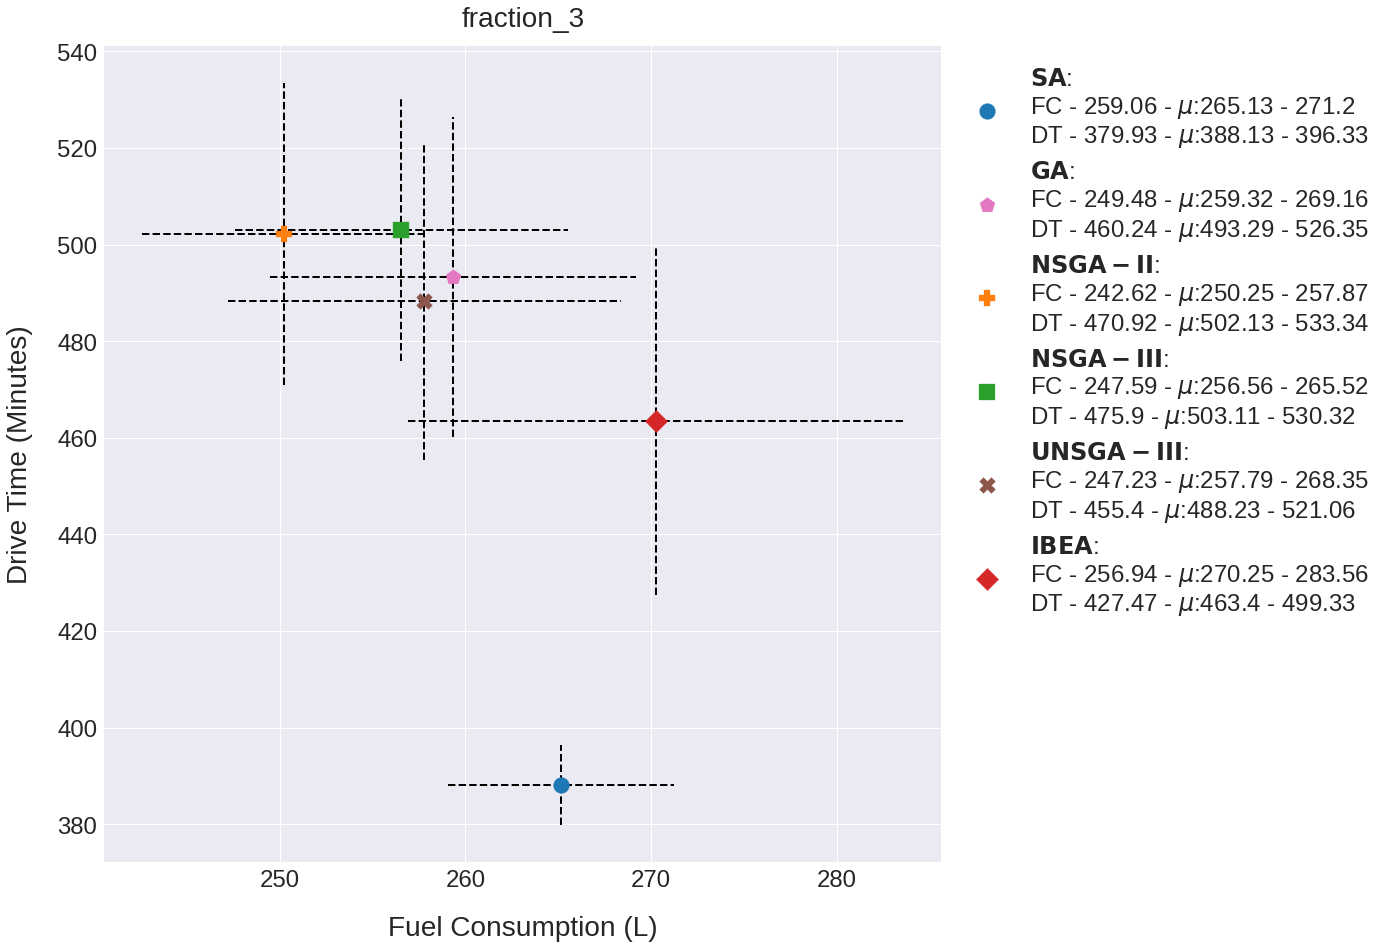

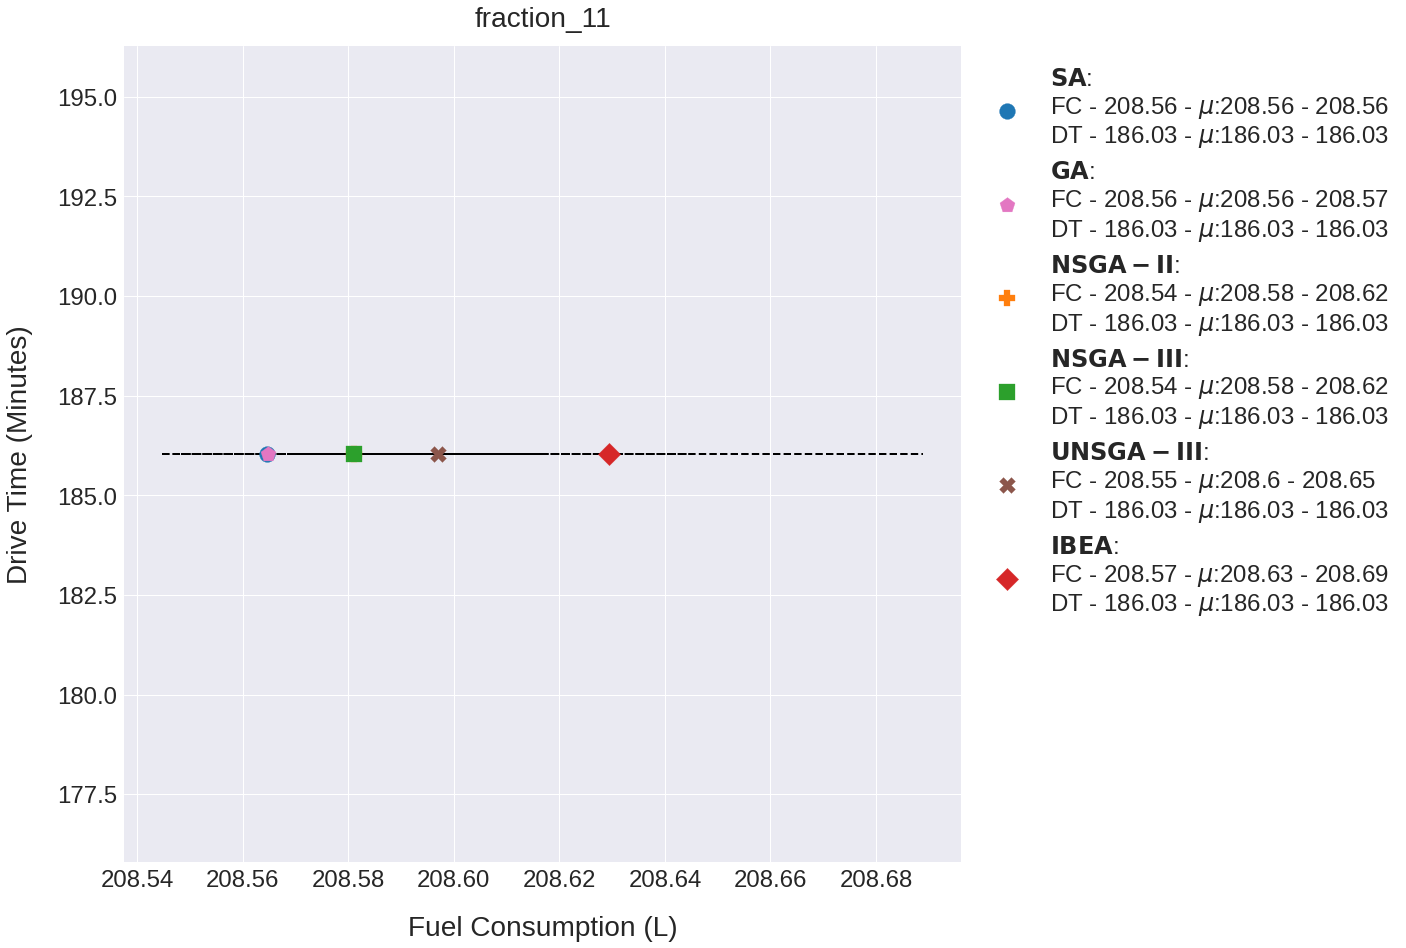

In [41]:
for dataset,sigma_sol,initial_sol in zip(dataset_names,get_sigma_results(),get_initial_results()):
    SA_data_dataset = SA_data.where(SA_data.dataset == dataset).dropna(how="all").mean()
    GA_data_dataset = GA_data.where(GA_data.dataset == dataset).dropna(how="all").mean()
    NSGA2_data_dataset = NSGA2_data.where(NSGA2_data.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data.where(NSGA3_data.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data.where(UNSGA3_data.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data.where(IBEA_data.dataset == dataset).dropna(how="all").mean()

    algorithms = [SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset]
    
    
    fig, ax = plot_2d_sigma(algorithms, labels)
    

    
    
    plt.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
    
    
    
    plt.title(dataset)
    plt.show()

In [274]:
sa_path = SA_data.where(SA_data.dataset=="fraction_3").dropna(how="all").sort_values(by="longest_route_time_final").paths.iloc[0]
sa_path = literal_eval(sa_path)
sa_numerical_path = get_numerical_path(sa_path,get_vehicles_for_fraction("3"))

In [300]:
vehicle_routes = []

for v_route in sa_numerical_path:
    vehicle_routes.append(decode_routes(generate_routes(sigma_coordinates[np.array(v_route)%len(sigma_routing_context.distance_matrix)] ,api)))

100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


In [306]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine
from folium.plugins import HeatMap, MarkerCluster
folium_map = folium.Map(location=(58.5476627, 13.9489607), tiles='openstreetmap', zoom_start=7,min_zoom=6)
colors = ["red", "blue", "green", "purple", "orange", "darkred", "cyan", "black"]
type_colors=["black","red","green"]
numerical_route = sa_numerical_path#get_numerical_path(plot_data_NSGAIII["paths"][0],vehicles)
for routeNumber,route in enumerate(numerical_route):

    routes = []
    
    for stop in route[::-1]:
        nodeType = 0
        if route.index(stop) == len(route)-1:
            nodeType =2
        if route.index(stop) == 0:
            nodeType =1
        coordinates = (sigma_coordinates[stop%len(sigma_routing_context.distance_matrix)][0],sigma_coordinates[stop%len(sigma_routing_context.distance_matrix)][1])
        routes.append(coordinates)
        Marker(coordinates,icon=folium.Icon(color=type_colors[nodeType],icon_color='#FFFF00')).add_to(folium_map)
  
    
    PolyLine(routes,color=colors[routeNumber%len(colors)]).add_to(folium_map)
    
        

folium_map


In [309]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine
from folium.plugins import HeatMap, MarkerCluster
folium_map = folium.Map(location=(58.5476627, 13.9489607), tiles='openstreetmap', zoom_start=7,min_zoom=6)
colors = ["red", "blue", "green", "purple", "orange", "darkred", "cyan", "black"]
type_colors=["black","red","green"]
numerical_route = sigma_routes[3][0]
for routeNumber,route in enumerate(numerical_route):

    routes = []
    
    for stop in route:
        nodeType = 0
        if route.index(stop) == len(route)-1:
            nodeType =1
        if route.index(stop) == 0:
            nodeType =2
        coordinates = (sigma_coordinates[stop%len(sigma_routing_context.distance_matrix)][0],sigma_coordinates[stop%len(sigma_routing_context.distance_matrix)][1])
        routes.append(coordinates)
        Marker(coordinates,icon=folium.Icon(color=type_colors[nodeType],icon_color='#FFFF00')).add_to(folium_map)
  
    
    PolyLine(routes,color=colors[routeNumber%len(colors)]).add_to(folium_map)
    
        

folium_map
